In [ ]:
#Codice calcolo portate
#Dati diaframma 
D=96 #mm
d=70.1 #mm
beta=d/D #rapporto di contrazione diaframma
#Dati misurati temperatura e pressione ambiente
T_amb=21 #gradi Celsius
p_amb=1026.1 #mbar
#correzione t amb e p amb
P_amb=((p_amb-0.000163*p_amb*T_amb)/1000*100000)
T_AMB=T_amb+273.15 # temperatura ambiente in Kelvin
#Geometria della batteria e del canale di scarico 
#Batteria
L1=236
H1=138
Area1=L1*H1*10**(-6) #area batteria in m^2
#Canale di scarico 
L2=151
H2=277
Area2=L2*H2*10**(-6) #area canale in m2

import pandas as pd
import numpy as np

# Importazione misure corrette da Excel
file_path = "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\misure-04-02-2025.xlsx"
leggi_misura = pd.read_excel(file_path, header=None)

# Converti il DataFrame in un array NumPy
Misure_vett = leggi_misura.to_numpy(dtype=float)
print(Misure_vett)




# PROCEDURA ITERATIVA PER IL CALCOLO DELLA PORTATA DI ARIA AL DIAFRAMMA 




In [101]:
import numpy as np

# Dati di input
mu = 0.000018
Dpdiaf_corr = Misure_vett[:, 6]
Pmdiaf_corr = Misure_vett[:, 5]
T_diaf = Misure_vett[:, 3]
beta = d / D  # Assicurati che beta sia definito correttamente
# Dati di input
Pamb = 1030.2*100
DpH2O_corr = Misure_vett[:, 7]
Dp_air_corr = Misure_vett[:, 4]
TH2Oin = Misure_vett[:, 0]
T_air = Misure_vett[:, 2]
TH2O_out_corr = Misure_vett[:, 1]
Q_H2O = Misure_vett[:, 8]  # Portata d'acqua nella batteria


# Lista per memorizzare le potenze
Powers = []
results=[]
# Costanti
gamma = 1.40  # esponente dell'iso-s
flow_rates = []  # Lista per memorizzare i flow rates

# Itera su ogni riga di Misure_vett
for i in range(Misure_vett.shape[0]):
    # Estrai i valori per la riga corrente
    Pmdiaf = Pmdiaf_corr[i]
    Dpdiaf = Dpdiaf_corr[i]
    T_diaf_current = T_diaf[i]
    DpH2O_curr=DpH2O_corr[i]
    # Calcolo delle variabili necessarie
    Pmd = P_amb - Pmdiaf * 100
    Dpdiaf = Dpdiaf * 100
    Rho_med = (P_amb - Pmdiaf * 100) / (287 * (T_diaf_current + 273.15))
    epsilon = 1 - (0.351 + 0.256 * beta ** 4 + 0.93 * beta ** 8) * (1 - (1 - (Dpdiaf / Pmd)) ** (1 / gamma))

    # Inizializzazione per il calcolo di c
    n = 1
    c = np.full((n,), 0.6)  # n è il numero di valori di c che desideri
    tolleranza = 1e-3  # tolleranza per la variazione di c
    c_old = c + 2 * tolleranza  # inizializza c_old a un valore diverso da c

    while np.any(np.abs(c - c_old) > tolleranza):
        c_old = c.copy()  # Copia i valori correnti di c in c_old
        # Calcolo portate
        alfa = c / (((1 - beta ** 4)) ** 0.5)
        flow_rate = alfa * epsilon * ((np.pi * (0.0701) ** 2) / 4) * (2 * Rho_med * Dpdiaf) ** 0.5
        v = flow_rate / (Rho_med * np.pi * 0.25 * 0.096 ** (2))
        Reynolds = Rho_med * v * 0.096 / mu
        A = ((19000 * beta) / Reynolds) ** 0.8
        L2 = 0.47
        M2 = 2 * L2 / (1 - beta)
        C = 0.5961 + 0.0261 * beta ** (2) - 0.216 * beta ** (8) + 0.000521 * (((10 ** 6) * beta) / Reynolds) ** 0.7 + (0.0188 + 0.0063 * A) * beta ** (3.5) * ((10 ** 6) / Reynolds) ** 0.3 + (0.043 + 0.08 * np.exp(-10) - 0.123 * np.exp(-7)) * (1 - 0.11 * A) * (beta ** (4) / (1 - beta ** (4))) - 0.031 * (M2 - 0.8 * M2 ** 1.1) * beta ** 1.3
        
        # Aggiorna c
        c = C

    # Salva il flow rate per la riga corrente
    flow_rates.append(flow_rate)

# Estrai i valori per la riga corrente - potenza della batteria 
    Dp_air_corr_curr = Dp_air_corr[i]
    TH2Oin_curr = TH2Oin[i]
    TH2O_out_corr_curr = TH2O_out_corr[i]
    T_air_curr = T_air[i]
    T_diaf_current = T_diaf[i]
    flow_rate_curr = flow_rates[i]
    Q_H2O_curr=Q_H2O[i]
    # Calcolo densità dell'aria in ingresso e in uscita
    Rho_air_in = Pamb / (287 * (T_air_curr + 273.15))
    Rho_air_out = (Pamb - Dp_air_corr_curr * 100) / (287 * (T_diaf_current + 273.15))

    # Calcolo velocità dell'aria in ingresso e in uscita
    V_air_in = flow_rate_curr / (Rho_air_in * Area1)
    V_air_out = flow_rate_curr / (Rho_air_out * Area2)

    # Salto di pressione dinamica dell'aria dopo il passaggio nella batteria
    Dp0_air = Dp_air_corr_curr * 100 + 0.5 * Rho_air_out * V_air_out ** 2

    # Differenza di temperatura aria-acqua
    DT_airH2O = TH2Oin_curr - T_air_curr
    # Calcolo della potenza termica scambiata (prestazione batteria)
    DT = abs(TH2O_out_corr_curr - TH2Oin_curr)
    if DT == 0:
        Power = 0  # o un valore predefinito, o un messaggio di errore
        print("ATTENZIONE: TH2O_out_corr_curr e TH2Oin_curr sono uguali!")
    else:
        Power = Q_H2O_curr / 60 * (4186 * DT)
    DTAW=TH2Oin_curr-T_air_curr
# Aggiungi i risultati alla lista
    results.append([Q_H2O_curr, flow_rate_curr, Rho_air_in, V_air_in, Rho_air_out, V_air_out, Dp0_air, DpH2O_curr, DT_airH2O, Power])

# Converti la lista in un DataFrame di pandas
results_df = pd.DataFrame(results, columns=["Q_H2O", "Flow Rate", "Rho Air In", "V Air In", "Rho Air Out", "V Air Out", "Dp0 Air", "Dp H2O Corr", "DT Air-Water", "Power"])

# Salva i risultati in un file Excel
output_file_path = "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-04-02-2025.xlsx"
results_df.to_excel(output_file_path, index=False, header=True)



# Importazione e visualizzazione dei risultati

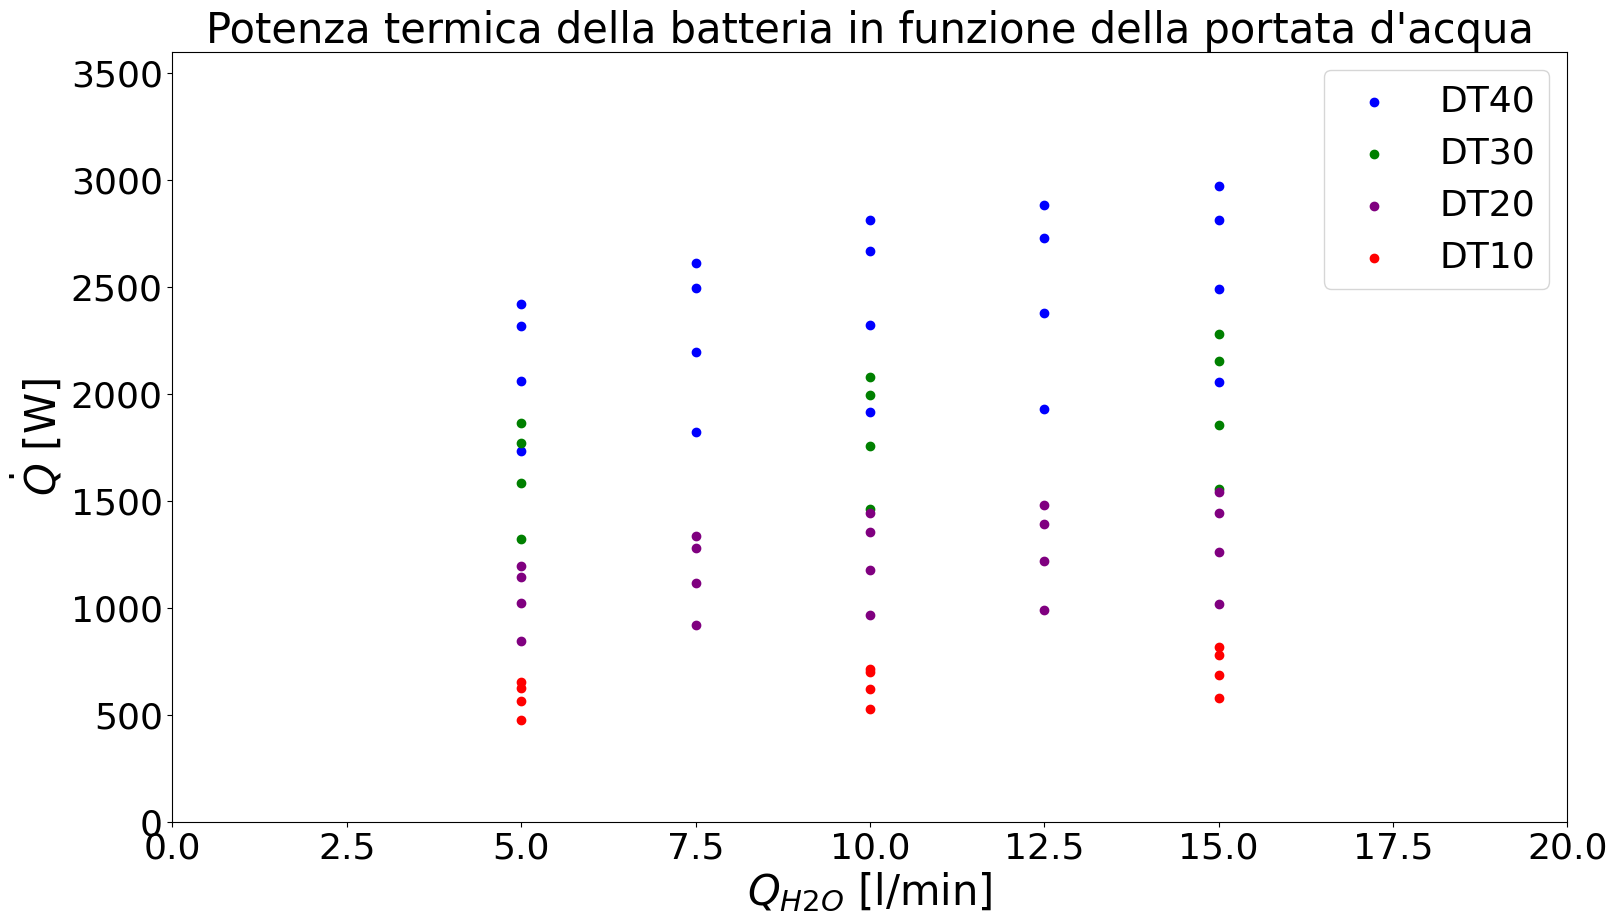

coefficienti [ 393.12529719 1080.39813851]
coefficienti [ 367.18213662 1014.20186142]
coefficienti [383.7903176  996.19607995]
coefficienti [ 327.85378939 1018.98571145]
coefficienti [ 287.76951129 1030.55276808]


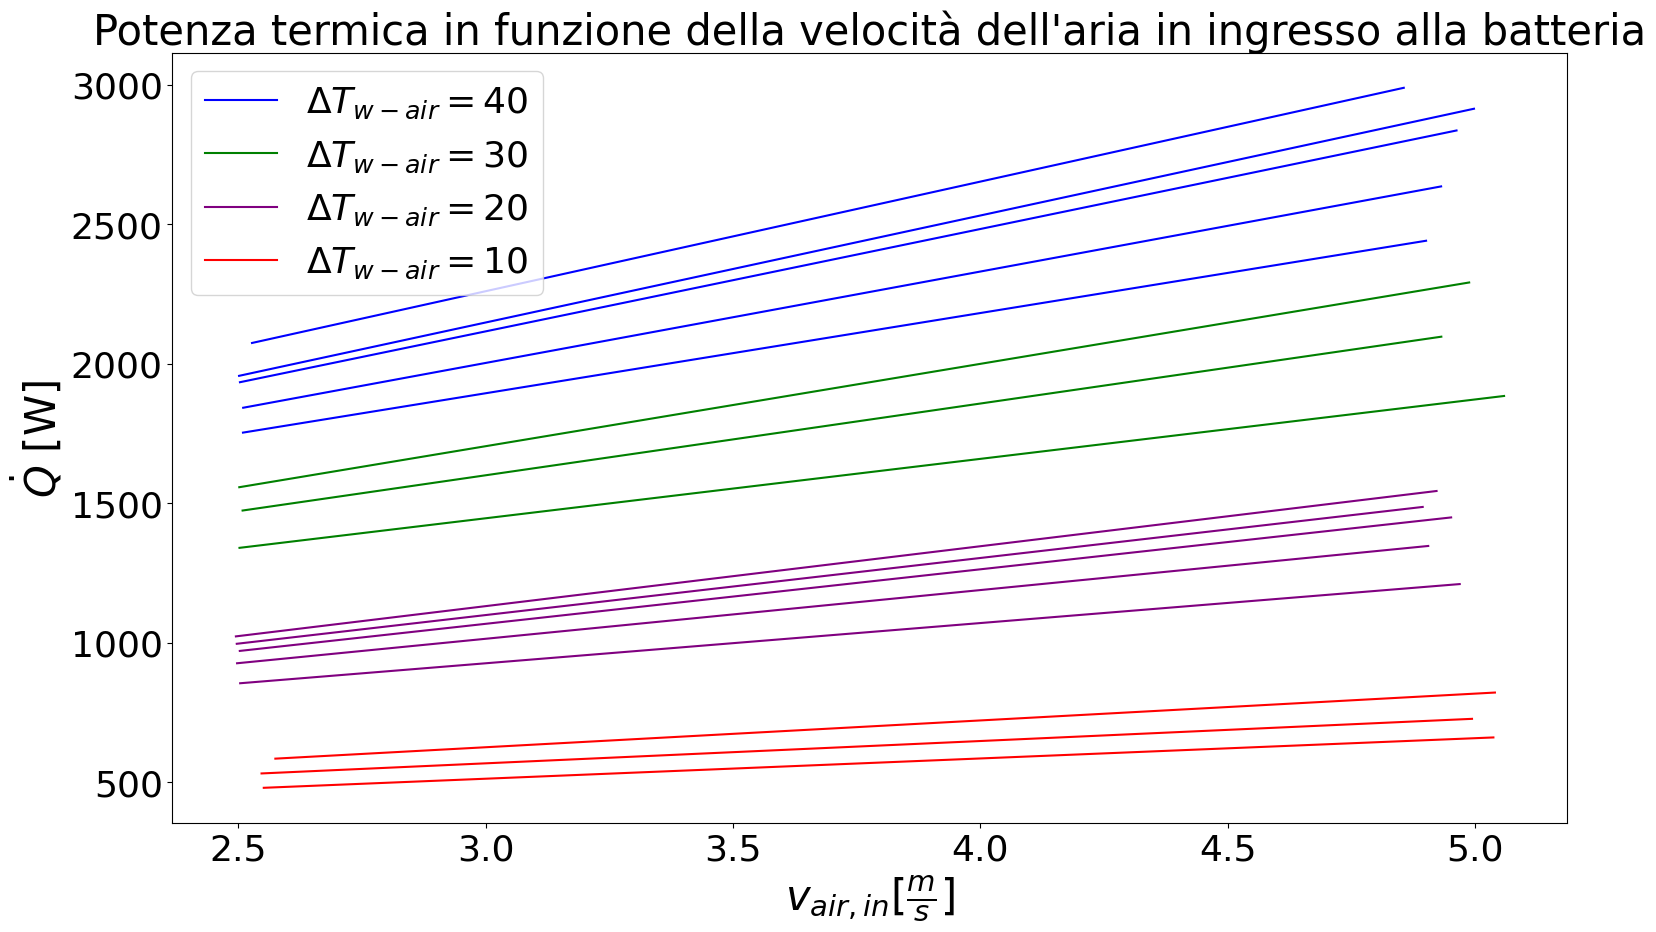

Coefficienti del polinomio (a, b, c): [ 2.74070065  7.12234149 -4.67071403]


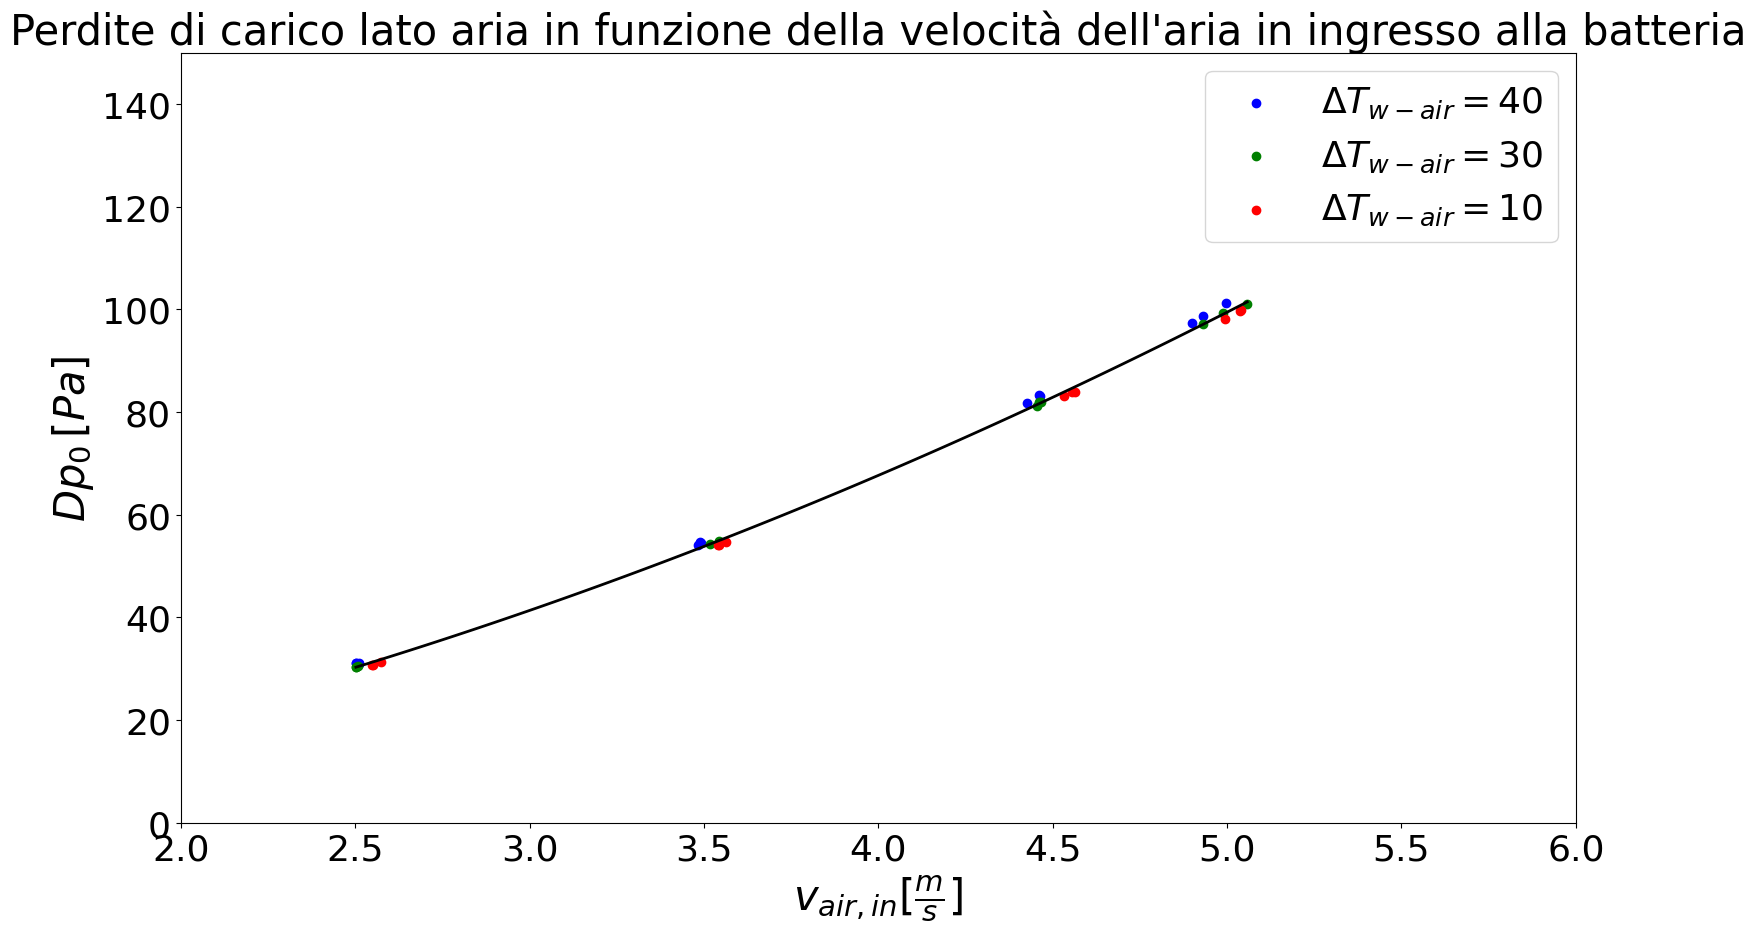

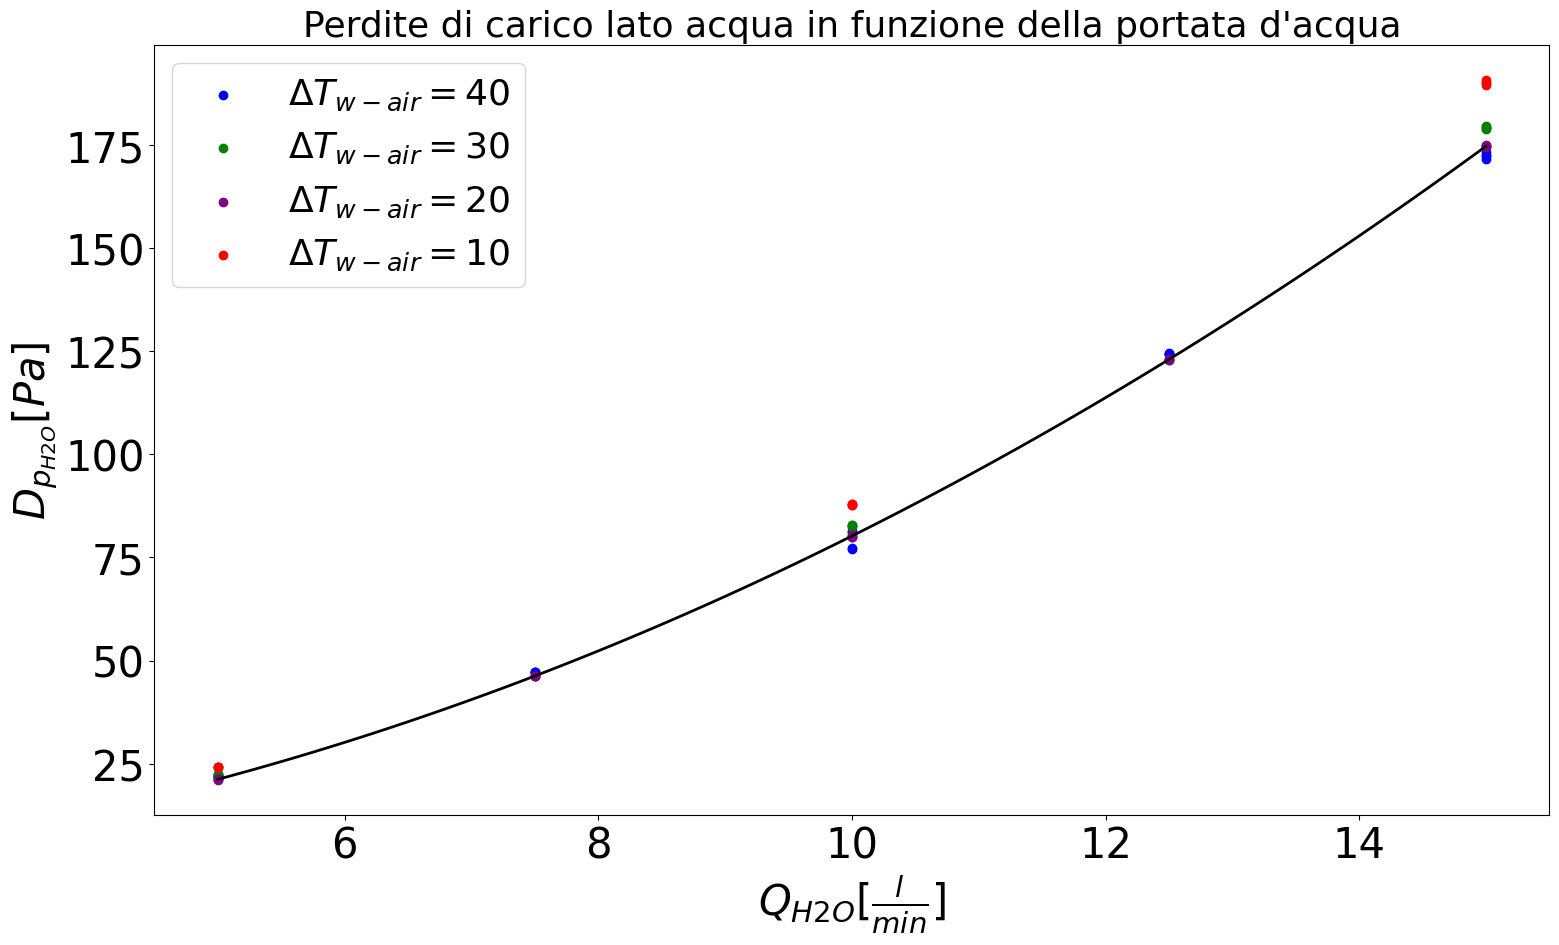

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Import numpy

# File paths
file_paths = [
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-03-02-2025.xlsx",
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-04-02-2025.xlsx",
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-05-02-2025.xlsx",
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-07-02-2025.xlsx",
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-10-02-2025.xlsx",
    "C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\risultati-DT40.xlsx"
]

# Import Excel files into DataFrames
dfs = [pd.read_excel(file_path, skiprows=0) for file_path in file_paths]

#Selezione del file con cui lavorare 
df0 = dfs [0]
df1 = dfs [1]
df2 = dfs [2]
df3 = dfs[3]  
df4 = dfs[4]
df5 = dfs [5]

# Selezione dei valori di portata e potenza 
Q0 = df0.iloc[:, 9]
QH2O0 = df0.iloc[:, 0] 
Q1 = df1.iloc[:, 9]  
QH2O1 = df1.iloc[:, 0]  
Q2=df2.iloc[:,9]
QH2O2 = df2.iloc[:, 0]
Q3 = df3.iloc[:, 9]  
QH2O3 = df3.iloc[:, 0]  
Q4=df4.iloc[:,9]
QH2O4 = df4.iloc[:, 0]
Q5=df5.iloc[:,9]
QH2O5 = df5.iloc[:, 0]
# Plot dati Potenza in funzione della portata d'acqua

plt.figure(figsize=(18,10))
plt.scatter(QH2O0, Q0, label='DT40', color='blue')
plt.scatter(QH2O1, Q1, color='blue')
plt.scatter(QH2O2, Q2, label='DT30', color='green')
plt.scatter(QH2O4, Q4, label='DT20', color='purple')
plt.scatter(QH2O3, Q3, label='DT10', color='red')
plt.xlabel("$Q_{H2O}$ [l/min]",fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.ylim(0,3600)
plt.xlim(0,20)
plt.title("Potenza termica della batteria in funzione della portata d'acqua",fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.legend(fontsize=26)
plt.show()


# Plot della potenza scambiata in funzione della velocità dell'aria
v0 = df0.iloc[:, 3]
v1 = df1.iloc[:, 3]
v2 = df2.iloc[:, 3]
v3 = df3.iloc[:, 3]
v4 = df4.iloc[:, 3]
v5 = df5.iloc[:, 3]

# Visualizzazione grafica
plt.figure(figsize=(18, 10))

# Fitting e interpolazione per DT40

for i in range(0, 20, 4):
    v_curr40 = v5[i:i+4]# Estrai 4 valori di velocità 
    power_curr40 = Q5[i:i+4]# Estrai 4 valori di potenza
    pol40 = np.polyfit(v_curr40, power_curr40, 1)  # Fitting lineare
    print('coefficienti' ,pol40)
    vel40 = np.linspace(min(v_curr40), max(v_curr40), num=100)  # Genera valori di velocità
    Q_interp40 = np.polyval(pol40, vel40)  # Calcola l'interpolazione

    # Plotta la curva di interpolazione
    if i==0:
        plt.plot(vel40, Q_interp40, label=r'$\Delta T_{w-air} = 40$', color='blue')
    else:
        plt.plot(vel40, Q_interp40, color='blue')


# Fitting e interpolazione per DT30
for i in range(0, 12, 4):
    v_curr30 = v2[i:i+4]  # Estrai 4 valori di velocità
    power_curr30 = Q2[i:i+4]  # Estrai 4 valori di potenza
    pol30 = np.polyfit(v_curr30, power_curr30, 1)  # Fitting lineare
    vel30 = np.linspace(min(v_curr30), max(v_curr30), num=100)  # Genera valori di velocità
    Q_interp30 = np.polyval(pol30, vel30)  # Calcola l'interpolazione

    # Plotta la curva di interpolazione
    if i==0:
        plt.plot(vel30, Q_interp30, label=r'$\Delta T_{w-air} = 30$', color='green')
    else:
        plt.plot(vel30, Q_interp30, color='green')


# Fitting e interpolazione per DT20

for i in range(0, 20, 4):
    v_curr20 = v4[i:i+4]# Estrai 4 valori di velocità 
    power_curr20 = Q4[i:i+4]# Estrai 4 valori di potenza
    pol20 = np.polyfit(v_curr20, power_curr20, 1)  # Fitting lineare
    vel20 = np.linspace(min(v_curr20), max(v_curr20), num=100)  # Genera valori di velocità
    Q_interp20 = np.polyval(pol20, vel20)  # Calcola l'interpolazione

    # Plotta la curva di interpolazione
    if i==0:
        plt.plot(vel20, Q_interp20, label=r'$\Delta T_{w-air} = 20$', color='purple')
    else:
        plt.plot(vel20, Q_interp20, color='purple')

# Fitting e interpolazione per DT10
for i in range(0, 12, 4):
    v_curr10 = v3[i:i+4]  # Estrai 4 valori di velocità
    power_curr10 = Q3[i:i+4]  # Estrai 4 valori di potenza
    pol10 = np.polyfit(v_curr10, power_curr10, 1)  # Fitting lineare
    vel10 = np.linspace(min(v_curr10), max(v_curr10), num=100)  # Genera valori di velocità
    Q_interp10 = np.polyval(pol10, vel10)  # Calcola l'interpolazione

    # Plotta la curva di interpolazione
    if i==0:
        plt.plot(vel10, Q_interp10, label=r'$\Delta T_{w-air} = 10$', color='red')
    else:
        plt.plot(vel10, Q_interp10, color='red')
plt.legend(fontsize=26)
plt.xlabel(r'$v_{air,in} [\frac{m}{s}]$',fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title('Potenza termica in funzione della velocità dell\'aria in ingresso alla batteria',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.show()

#perdite di carico aria
Dp0 = df0.iloc[:, 6]
Dp1 = df1.iloc[:, 6]
Dp2 = df2.iloc[:, 6]
Dp3 = df3.iloc[:, 6]
Dp5 = df5.iloc[:,6]
plt.figure(figsize=(18,10))
# Curva perdite di carico lato aria

v_curr = v2  # Estrai 4 valori di velocità
Dp0_air = Dp2  # Estrai 4 valori di potenza
pol_dp0 = np.polyfit(v_curr, Dp0_air, 2)  # Fitting quadratico
velocity = np.linspace(min(v_curr), max(v_curr), num=100)  # Genera valori di velocità
Dp0_interp = np.polyval(pol_dp0, velocity)  # Calcola l'interpolazione
# Plotta la curva di interpolazione
print("Coefficienti del polinomio (a, b, c):", pol_dp0)
plt.plot(velocity, Dp0_interp, color='black',linewidth=2)
plt.scatter(v1 ,Dp1, label=r'$\Delta T_{w-air} = 40$', color='blue')
plt.scatter(v2 ,Dp2, label=r'$\Delta T_{w-air} = 30$', color='green')
plt.scatter(v3 ,Dp3, label=r'$\Delta T_{w-air} = 10$', color='red')
plt.xlim([2,6])
plt.ylim([0,150])
plt.xlabel(r'$v_{air,in} [\frac{m}{s}]$',fontsize=30)
plt.ylabel(r'$Dp_{0} \, [Pa]$', fontsize=30)
plt.title('Perdite di carico lato aria in funzione della velocità dell\'aria in ingresso alla batteria',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.legend(fontsize=26)
plt.show()




# Estrai le perdite di carico
DpW0 = df0.iloc[:, 7]
DpW1 = df1.iloc[:, 7]
DpW2 = df2.iloc[:, 7]
DpW3 = df3.iloc[:, 7]
DpW4 = df4.iloc[:, 7]

# Plot dei dati
plt.figure(figsize=(18, 10))

Flow = QH2O4  # Estrai 4 valori di portata
DpWater = DpW4  # Estrai 4 valori di perdite di carico
polW = np.polyfit(Flow, DpWater, 2)  # Fitting quadratico

F = np.linspace(min(Flow), max(Flow), num=100)  # Genera valori di portata
DpW_interp = np.polyval(polW, F)  # Calcola l'interpolazione
# Plotta la curva di interpolazione
plt.plot(F, DpW_interp, color='black', linewidth=2)

# Plotta i dataset
plt.scatter(QH2O0, DpW0, color='blue')
plt.scatter(QH2O1, DpW1, label=r'$\Delta T_{w-air} = 40$', color='blue')
plt.scatter(QH2O2, DpW2, label=r'$\Delta T_{w-air} = 30$', color='green')
plt.scatter(QH2O4, DpW4, label=r'$\Delta T_{w-air} = 20$', color='purple')
plt.scatter(QH2O3, DpW3, label=r'$\Delta T_{w-air} = 10$', color='red')

plt.legend(fontsize=26)
plt.xlabel(r'$Q_{H2O} [\frac{l}{min}]$',fontsize=30)
plt.ylabel(r'$D_{p_{H2O}} [Pa]$',fontsize=30)
plt.title('Perdite di carico lato acqua in funzione della portata d\'acqua',fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.show()


# Interpolazione dei dati sperimentali

Obiettivo: inserire un valore qualsiasi delle variabili presenti tra velocità dell'aria, $\Delta T$ aria-acqua e portata d'acqua e ricavare il valore corrispondente di potenza termica scambiata.

In [3]:
# Dati di velocità 

v0 = df0.iloc[:, 3]
v1 = df1.iloc[:, 3]
v2 = df2.iloc[:, 3]
v3 = df3.iloc[:, 3]
v4 = df4.iloc[:, 3]

# Dati di portata
QH2O0 = df0.iloc[:, 0]
QH2O1 = df1.iloc[:, 0]
QH2O2 = df2.iloc[:, 0]
QH2O3 = df3.iloc[:, 0] 
QH2O4 = df4.iloc[:, 0]

# Dati Delta_t aria-acqua

DT0 = df0.iloc[:,8]
DT1 = df1.iloc[:,8]
DT2 = df2.iloc[:,8]
DT3 = df3.iloc[:,8]
DT4 = df4.iloc[:,8]

# Dati potenza termica scambiata 

Q0 = df0.iloc[:, 9]
Q1 = df1.iloc[:, 9]
Q2 = df2.iloc[:, 9]
Q3 = df3.iloc[:, 9]
Q4 = df4.iloc[:, 9]

import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator

# Dati in un singolo DataFrame combinati
data = {
    'velocity': np.concatenate([v0, v1, v2, v3, v4]),
    'flow_rate': np.concatenate([QH2O0, QH2O1, QH2O2, QH2O3, QH2O4]),
    'delta_t': np.concatenate([DT0, DT1, DT2, DT3, DT4]),
    'power': np.concatenate([Q0, Q1, Q2, Q3, Q4])
}

df = pd.DataFrame(data)


# Funzione per interpolazione dei dati sperimentali

interpolator = LinearNDInterpolator(
    points=df[['velocity', 'flow_rate', 'delta_t']].values,
    values=df['power'].values
)

# Funzione per stimare la potenza sulla base dei dati sperimentali

def estimate_power(velocity, flow_rate, delta_t):
    return interpolator(velocity, flow_rate, delta_t)


# Valori in input 
velocity_input = float(input('Velocità aria in [m/s]:'))  
flow_rate_input = float(input('Portata acqua in [l/min]:'))   
delta_t_input =   float(input('Delta T aria-acqua in [K]:')) 

# Interpolazione dei dati per stimare la potenza termica scambiata

power_output = estimate_power(velocity_input, flow_rate_input, delta_t_input)

print(f"Estimated Power : {power_output:.2f}  W")


Estimated Power : 1398.06  W


# Stima della velocità media dell'aria in ingresso allo scambiatore data dal ventilatore a contatto con lo scambiatore (aria esterna ferma)

In [4]:

data_v = {
    'power_v': np.concatenate([Q0, Q1, Q2, Q3, Q4]),
    'flow_rate': np.concatenate([QH2O0, QH2O1, QH2O2, QH2O3, QH2O4]),
    'delta_t': np.concatenate([DT0, DT1, DT2, DT3, DT4]),
    'velocity': np.concatenate([v0, v1, v2, v3, v4])
}

df = pd.DataFrame(data_v)

# Funzione per interpolazione dei dati sperimentali
interpolator_v = LinearNDInterpolator(
    points=df[['power_v', 'flow_rate', 'delta_t']].values,
    values=df['velocity'].values
)

# Funzione per stimare la velocità sulla base dei dati sperimentali
def estimate_velocity(power_v, flow_rate, delta_t):
    return interpolator_v(power_v, flow_rate, delta_t)


# Valori in input 
power_input = float(input('Potenza termica misurata in [W]:'))  
flow_rate_input = float(input('Portata acqua in [l/min]:'))   
delta_t_input =   float(input('Delta T aria-acqua in [K]:')) 

# Interpolazione dei dati per stimare la velocità dell'aria

velocity_output = estimate_velocity(power_input, flow_rate_input, delta_t_input)

print(f"Estimated Velocity: {velocity_output:.2f}  m/s ")


ValueError: could not convert string to float: ''

# Determinazione coefficienti di porosità scambiatore di calore per la simulazione in STAR CCM+

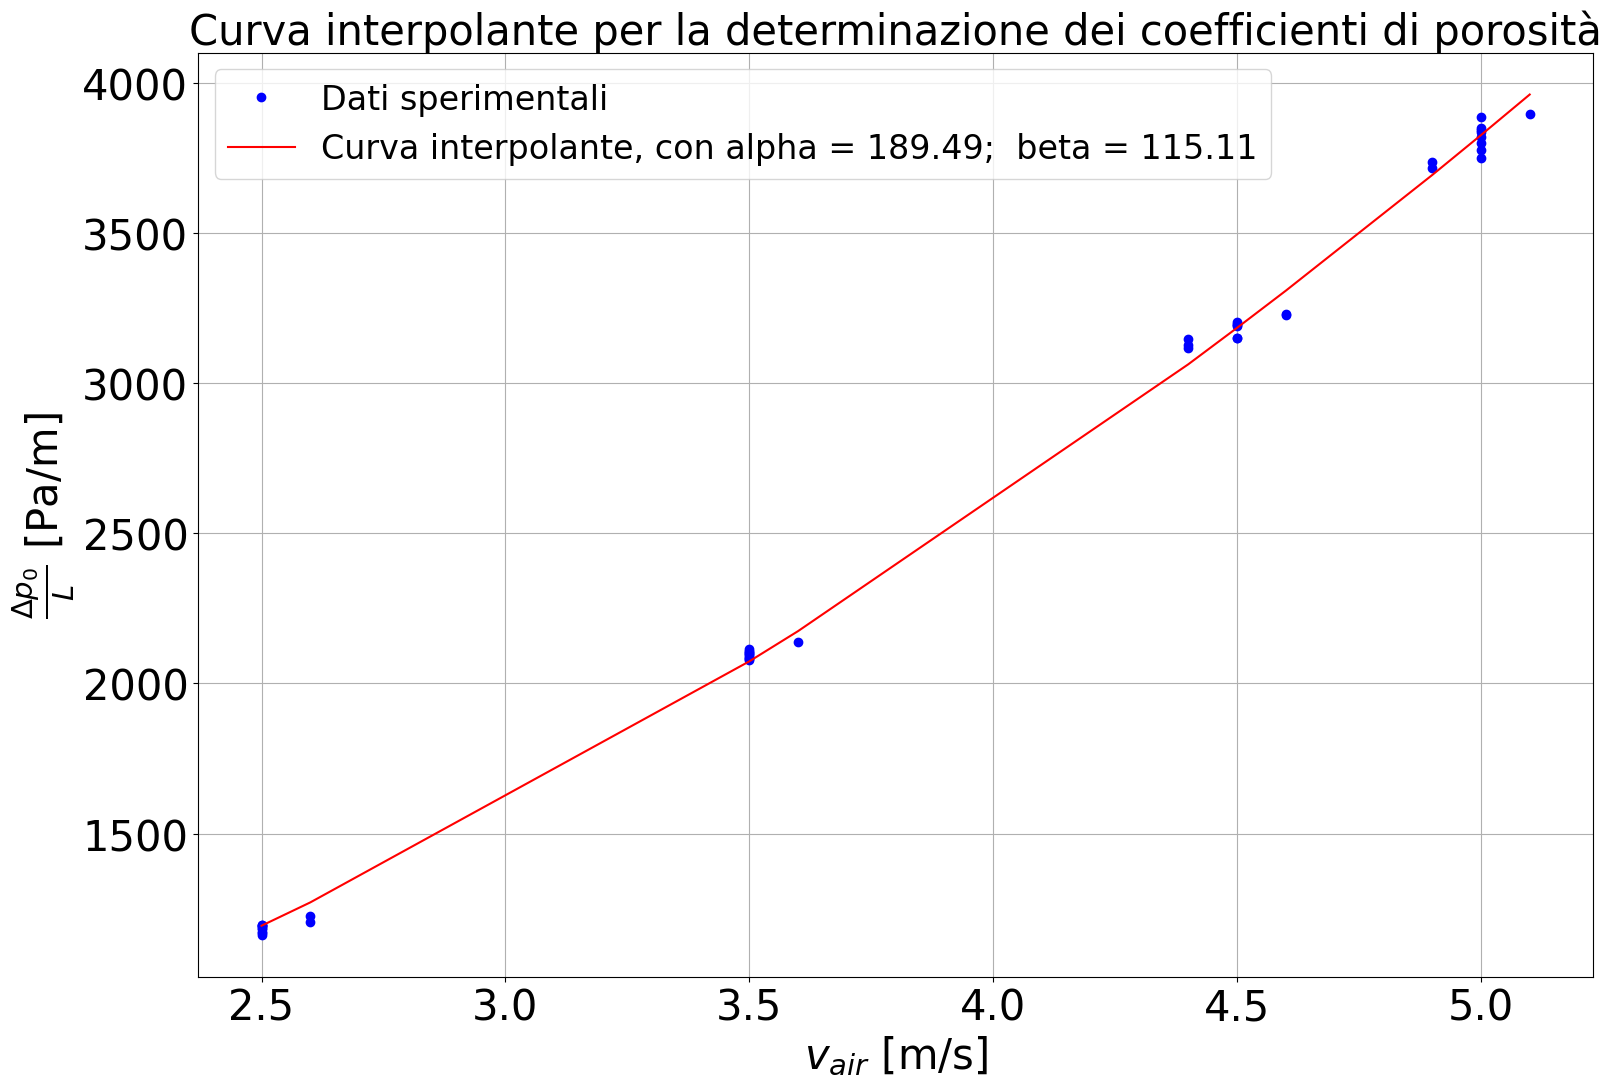

In [15]:
from scipy.optimize import curve_fit

filepath1="C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\Perdite di carico aria.txt"
filepath2="C:\\Users\\MEDIA\\Dropbox\\Il mio PC (DESKTOP-5MOS4OL)\\Desktop\\TESI MAGISTRALE\\Velocità aria.txt"

data1=np.loadtxt(filepath1)
data2=np.loadtxt(filepath2)
L = 26 * 10**(-3)
v_air = data2 # Velocità dell'aria
Pressure_loss = data1/L  # Perdite di carico
#definizione della funzione per il fitting

def dp(v_air,alpha,beta):
    return alpha*v_air+beta*v_air**2

params, covariance = curve_fit(dp, v_air, Pressure_loss)

# Estrazione dei parametri
alpha = params[0]
beta = params[1]

plt.figure(figsize=(18,12))
plt.plot(v_air, Pressure_loss, 'bo', label='Dati sperimentali') 
plt.plot(v_air, dp(v_air,alpha,beta)  , 'r-', label=f'Curva interpolante, con alpha = {alpha:.2f};  beta = {beta:.2f}') 
plt.xlabel('$v_{air}$ [m/s]', fontsize=30)
plt.ylabel(r'$\frac{\Delta p_0}{L}$ [Pa/m]', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)


plt.title('Curva interpolante per la determinazione dei coefficienti di porosità',fontsize=30)
plt.legend(fontsize=24)
plt.grid()
plt.show()

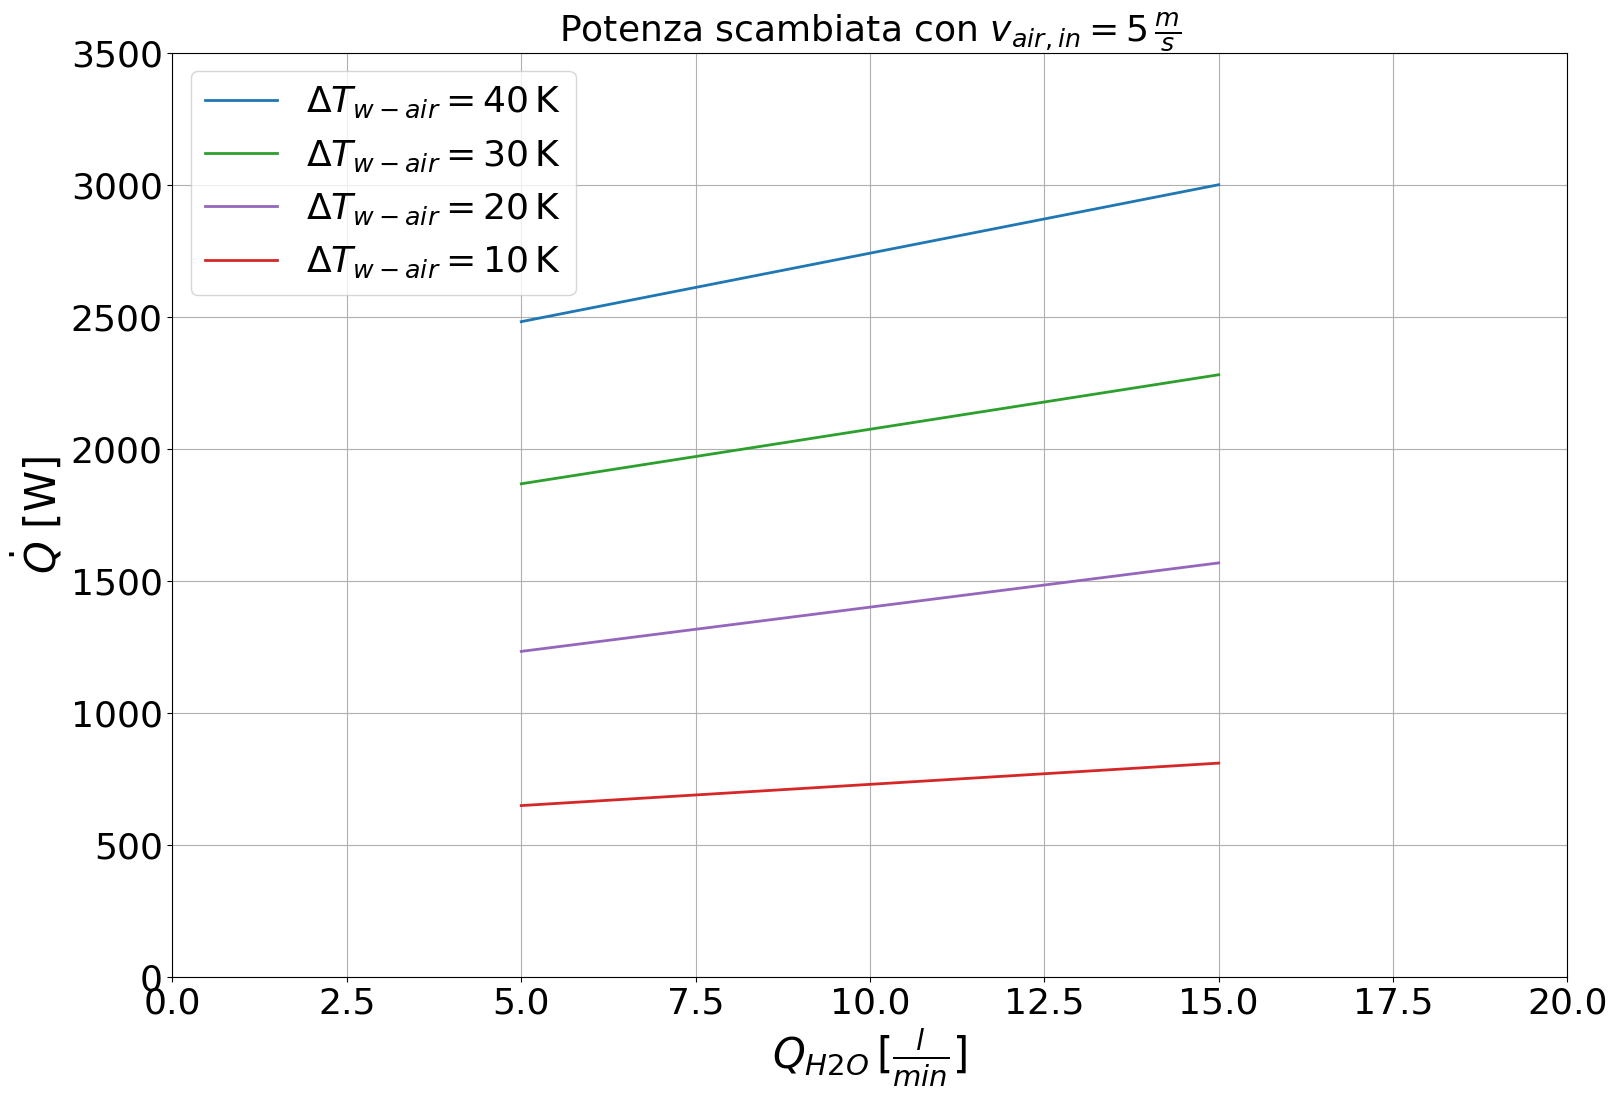

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definisci il percorso del file Excel
file_path = "C:/Users/MEDIA/Dropbox/Il mio PC (DESKTOP-5MOS4OL)/Desktop/TESI MAGISTRALE/Code_portate.xlsx"

# Carica il file Excel (header=0 indica che la prima riga contiene i nomi delle variabili)
df = pd.read_excel(file_path, header=0)

# Colori distinti per ogni fitting lineare (usati codici esadecimali)
colors = ['#1f77b4', '#2ca02c', '#d62728',  '#9467bd']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=12 pollici, altezza=8 pollici)

# Prendi i primi 5 valori
x1 = df['Q_H2O [l/min]'].iloc[0:5].values
y1 = df['Power [W]'].iloc[0:5].values
fit_and_plot(x1, y1, r'$\Delta T_{w-air} = 40 \, \text{K}$', colors[0])

# Prendi i successivi 3 valori
x2 = df['Q_H2O [l/min]'].iloc[5:8].values
y2 = df['Power [W]'].iloc[5:8].values
fit_and_plot(x2, y2, r'$\Delta T_{w-air} = 30 \, \text{K}$', colors[1])

# Prendi i successivi 5 valori
x3 = df['Q_H2O [l/min]'].iloc[8:13].values
y3 = df['Power [W]'].iloc[8:13].values
fit_and_plot(x3, y3, r'$\Delta T_{w-air} = 20 \, \text{K}$', colors[3])

# Prendi gli ultimi 3 valori
x4 = df['Q_H2O [l/min]'].iloc[13:16].values
y4 = df['Power [W]'].iloc[13:16].values
fit_and_plot(x4, y4, r'$\Delta T_{w-air} = 10 \, \text{K}$', colors[2])

# Imposta le etichette e il titolo
plt.xlabel(r'$Q_{H2O} \, [\frac{l}{min}]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title(r'Potenza scambiata con $v_{air,in} = 5 \, \frac{m}{s}$', fontsize=26)
plt.legend(fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 20)
plt.ylim(0, 3500)
# Mostra il grafico
plt.show()



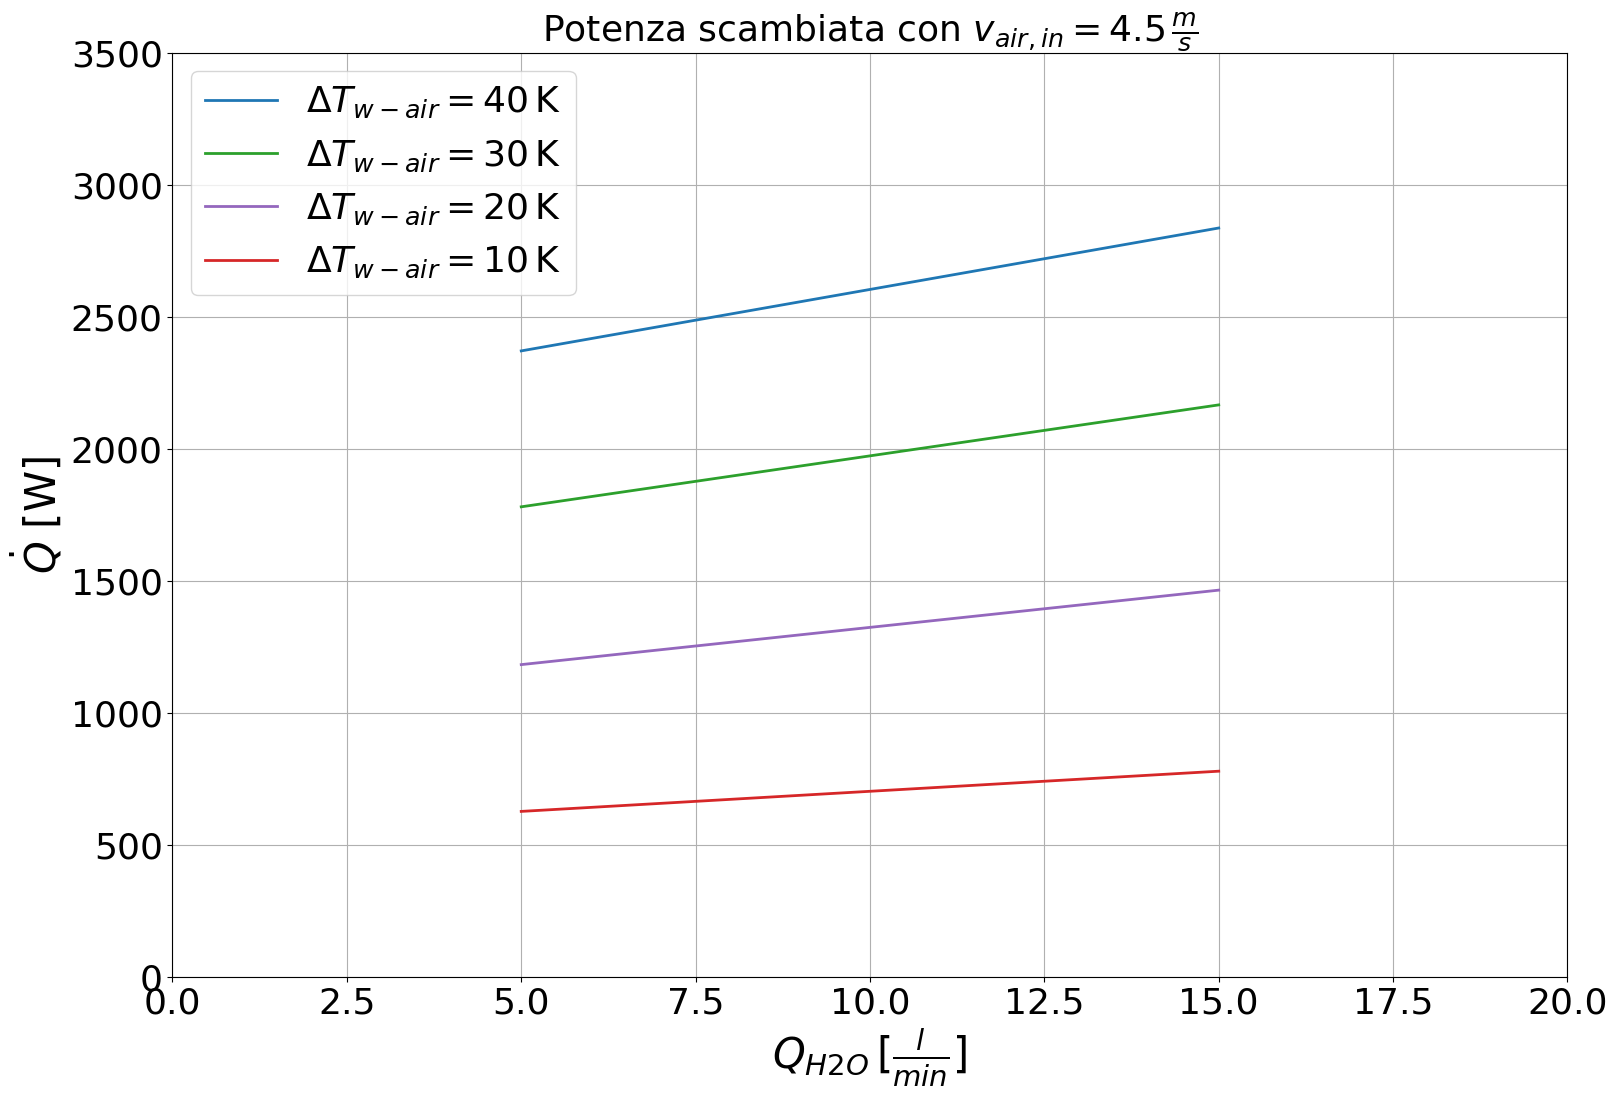

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definisci il percorso del file Excel
file_path = "C:/Users/MEDIA/Dropbox/Il mio PC (DESKTOP-5MOS4OL)/Desktop/TESI MAGISTRALE/Code_portate_2.xlsx"

# Carica il file Excel (header=0 indica che la prima riga contiene i nomi delle variabili)
df = pd.read_excel(file_path, header=0)

# Colori distinti per ogni fitting lineare (usati codici esadecimali)
colors = ['#1f77b4', '#2ca02c', '#d62728',  '#9467bd']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=12 pollici, altezza=8 pollici)

# Prendi i primi 5 valori
x1 = df['Q_H2O [l/min]'].iloc[0:5].values
y1 = df['Power [W]'].iloc[0:5].values
fit_and_plot(x1, y1, r'$\Delta T_{w-air} = 40 \, \text{K}$', colors[0])

# Prendi i successivi 3 valori
x2 = df['Q_H2O [l/min]'].iloc[5:8].values
y2 = df['Power [W]'].iloc[5:8].values
fit_and_plot(x2, y2, r'$\Delta T_{w-air} = 30 \, \text{K}$', colors[1])

# Prendi i successivi 5 valori
x3 = df['Q_H2O [l/min]'].iloc[8:13].values
y3 = df['Power [W]'].iloc[8:13].values
fit_and_plot(x3, y3, r'$\Delta T_{w-air}  = 20 \, \text{K}$', colors[3])

# Prendi gli ultimi 3 valori
x4 = df['Q_H2O [l/min]'].iloc[13:16].values
y4 = df['Power [W]'].iloc[13:16].values
fit_and_plot(x4, y4, r'$\Delta T_{w-air}  = 10 \, \text{K}$', colors[2])

# Imposta le etichette e il titolo
plt.xlabel(r'$Q_{H2O} \, [\frac{l}{min}]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title(r'Potenza scambiata con $v_{air,in} = 4.5 \, \frac{m}{s}$', fontsize=26)
plt.legend(fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 20)
plt.ylim(0, 3500)

# Mostra il grafico
plt.show()

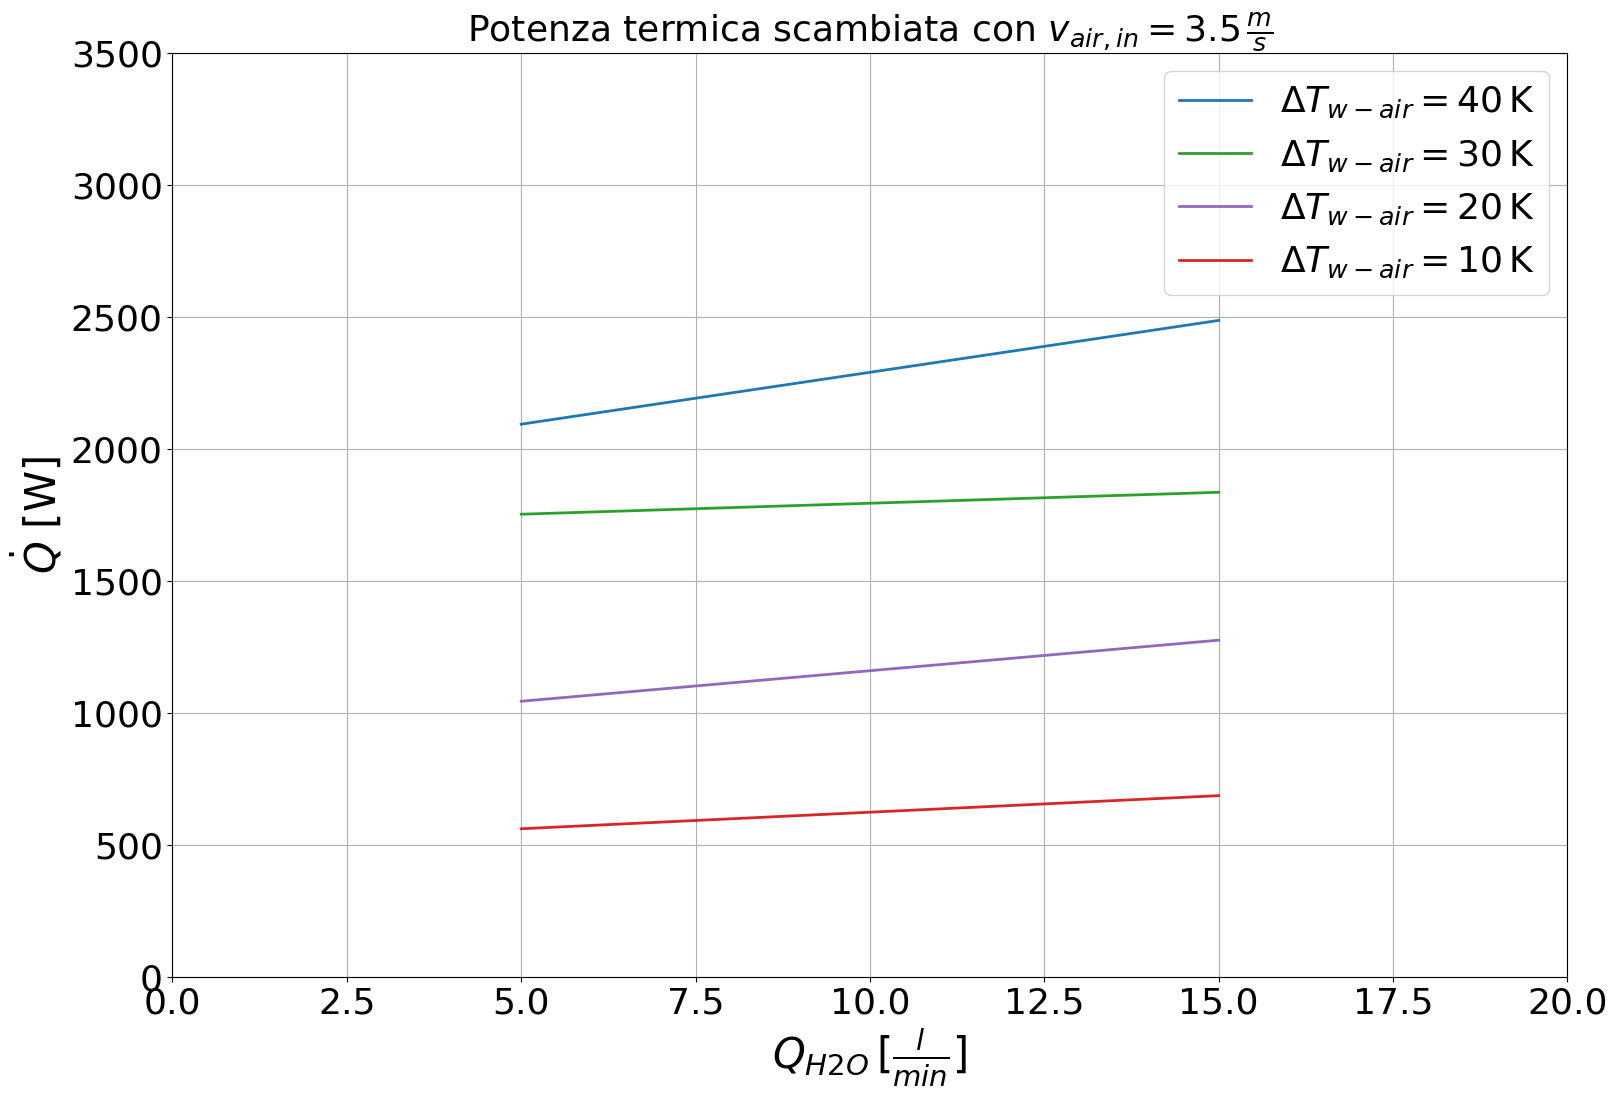

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definisci il percorso del file Excel
file_path = "C:/Users/MEDIA/Dropbox/Il mio PC (DESKTOP-5MOS4OL)/Desktop/TESI MAGISTRALE/Code_portate_3.xlsx"

# Carica il file Excel (header=0 indica che la prima riga contiene i nomi delle variabili)
df = pd.read_excel(file_path, header=0)

# Colori distinti per ogni fitting lineare (usati codici esadecimali)
colors = ['#1f77b4', '#2ca02c', '#d62728',  '#9467bd']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=12 pollici, altezza=8 pollici)

# Prendi i primi 5 valori
x1 = df['Q_H2O [l/min]'].iloc[0:5].values
y1 = df['Power [W]'].iloc[0:5].values
fit_and_plot(x1, y1, r'$\Delta T_{w-air} = 40 \, \text{K}$', colors[0])

# Prendi i successivi 3 valori
x2 = df['Q_H2O [l/min]'].iloc[5:8].values
y2 = df['Power [W]'].iloc[5:8].values
fit_and_plot(x2, y2, r'$\Delta T_{w-air} = 30 \, \text{K}$', colors[1])

# Prendi i successivi 5 valori
x3 = df['Q_H2O [l/min]'].iloc[8:13].values
y3 = df['Power [W]'].iloc[8:13].values
fit_and_plot(x3, y3, r'$\Delta T_{w-air} = 20 \, \text{K}$', colors[3])

# Prendi gli ultimi 3 valori
x4 = df['Q_H2O [l/min]'].iloc[13:16].values
y4 = df['Power [W]'].iloc[13:16].values
fit_and_plot(x4, y4, r'$\Delta T_{w-air} = 10 \, \text{K}$', colors[2])

# Imposta le etichette e il titolo
plt.xlabel(r'$Q_{H2O} \, [\frac{l}{min}]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title(r'Potenza termica scambiata con $v_{air,in} = 3.5 \, \frac{m}{s}$', fontsize=26)
plt.legend(fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 20)
plt.ylim(0, 3500)

# Mostra il grafico
plt.show()

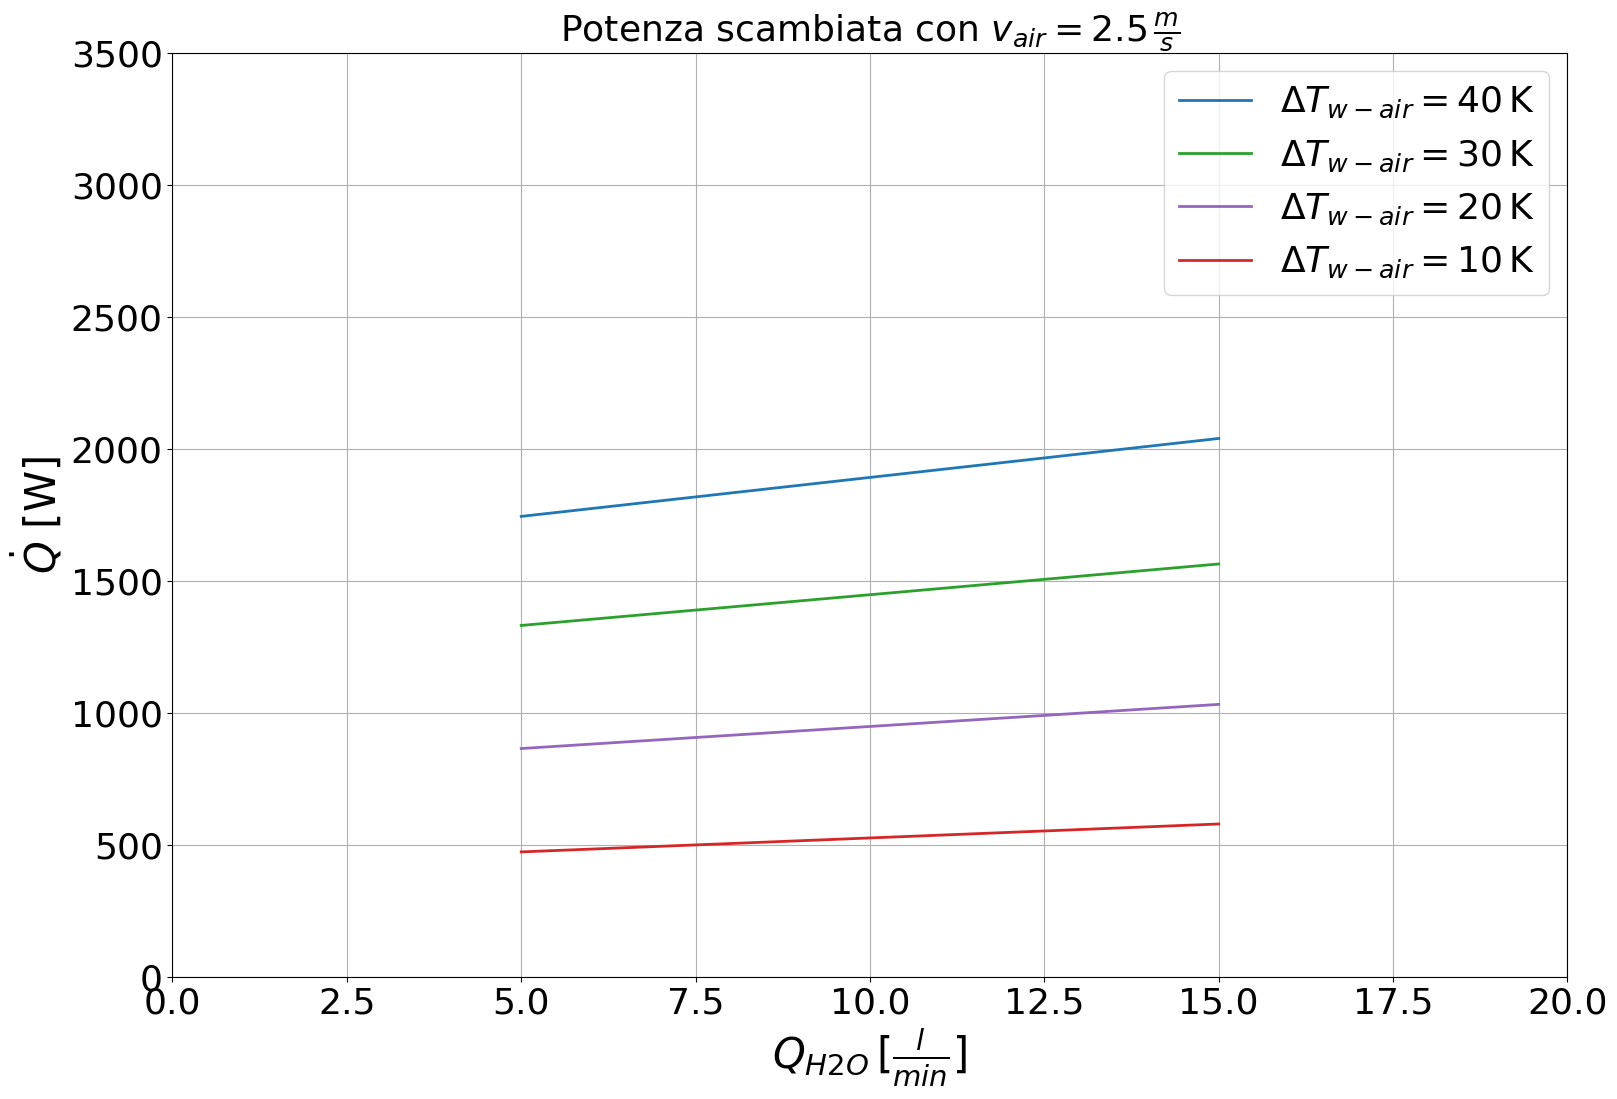

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definisci il percorso del file Excel
file_path = "C:/Users/MEDIA/Dropbox/Il mio PC (DESKTOP-5MOS4OL)/Desktop/TESI MAGISTRALE/Code_portate_4.xlsx"

# Carica il file Excel (header=0 indica che la prima riga contiene i nomi delle variabili)
df = pd.read_excel(file_path, header=0)

# Colori distinti per ogni fitting lineare (usati codici esadecimali)
colors = ['#1f77b4', '#2ca02c', '#d62728',  '#9467bd']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=12 pollici, altezza=8 pollici)

# Prendi i primi 5 valori
x1 = df['Q_H2O [l/min]'].iloc[0:5].values
y1 = df['Power [W]'].iloc[0:5].values
fit_and_plot(x1, y1, r'$\Delta T_{w-air} = 40 \, \text{K}$', colors[0])

# Prendi i successivi 3 valori
x2 = df['Q_H2O [l/min]'].iloc[5:8].values
y2 = df['Power [W]'].iloc[5:8].values
fit_and_plot(x2, y2, r'$\Delta T_{w-air} = 30 \, \text{K}$', colors[1])

# Prendi i successivi 5 valori
x3 = df['Q_H2O [l/min]'].iloc[8:13].values
y3 = df['Power [W]'].iloc[8:13].values
fit_and_plot(x3, y3, r'$\Delta T_{w-air} = 20 \, \text{K}$', colors[3])

# Prendi gli ultimi 3 valori
x4 = df['Q_H2O [l/min]'].iloc[13:16].values
y4 = df['Power [W]'].iloc[13:16].values
fit_and_plot(x4, y4, r'$\Delta T_{w-air} = 10 \, \text{K}$', colors[2])

# Imposta le etichette e il titolo
plt.xlabel(r'$Q_{H2O} \, [\frac{l}{min}]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title(r'Potenza scambiata con $v_{air} = 2.5 \, \frac{m}{s}$', fontsize=26)
plt.legend(fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 20)
plt.ylim(0, 3500)

# Mostra il grafico
plt.show()

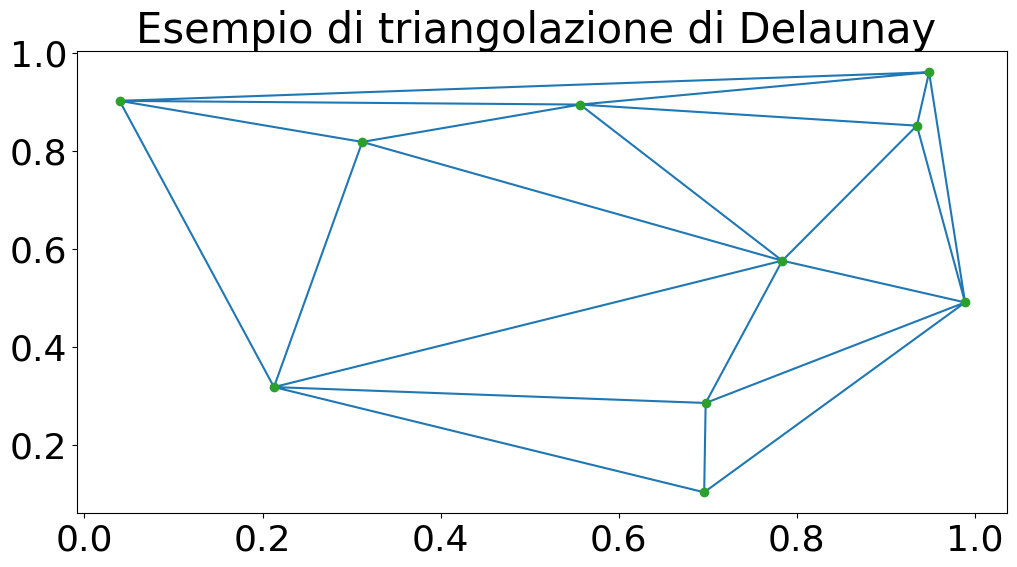

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Crea alcuni punti casuali in 2D
points = np.random.rand(10, 2)

# Calcola la triangolazione
tri = Delaunay(points)

# Grafico
plt.figure(figsize=(12, 6))
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.tick_params(axis='both', which='major', labelsize=26)
plt.title('Esempio di triangolazione di Delaunay ', fontsize=30)
plt.show()

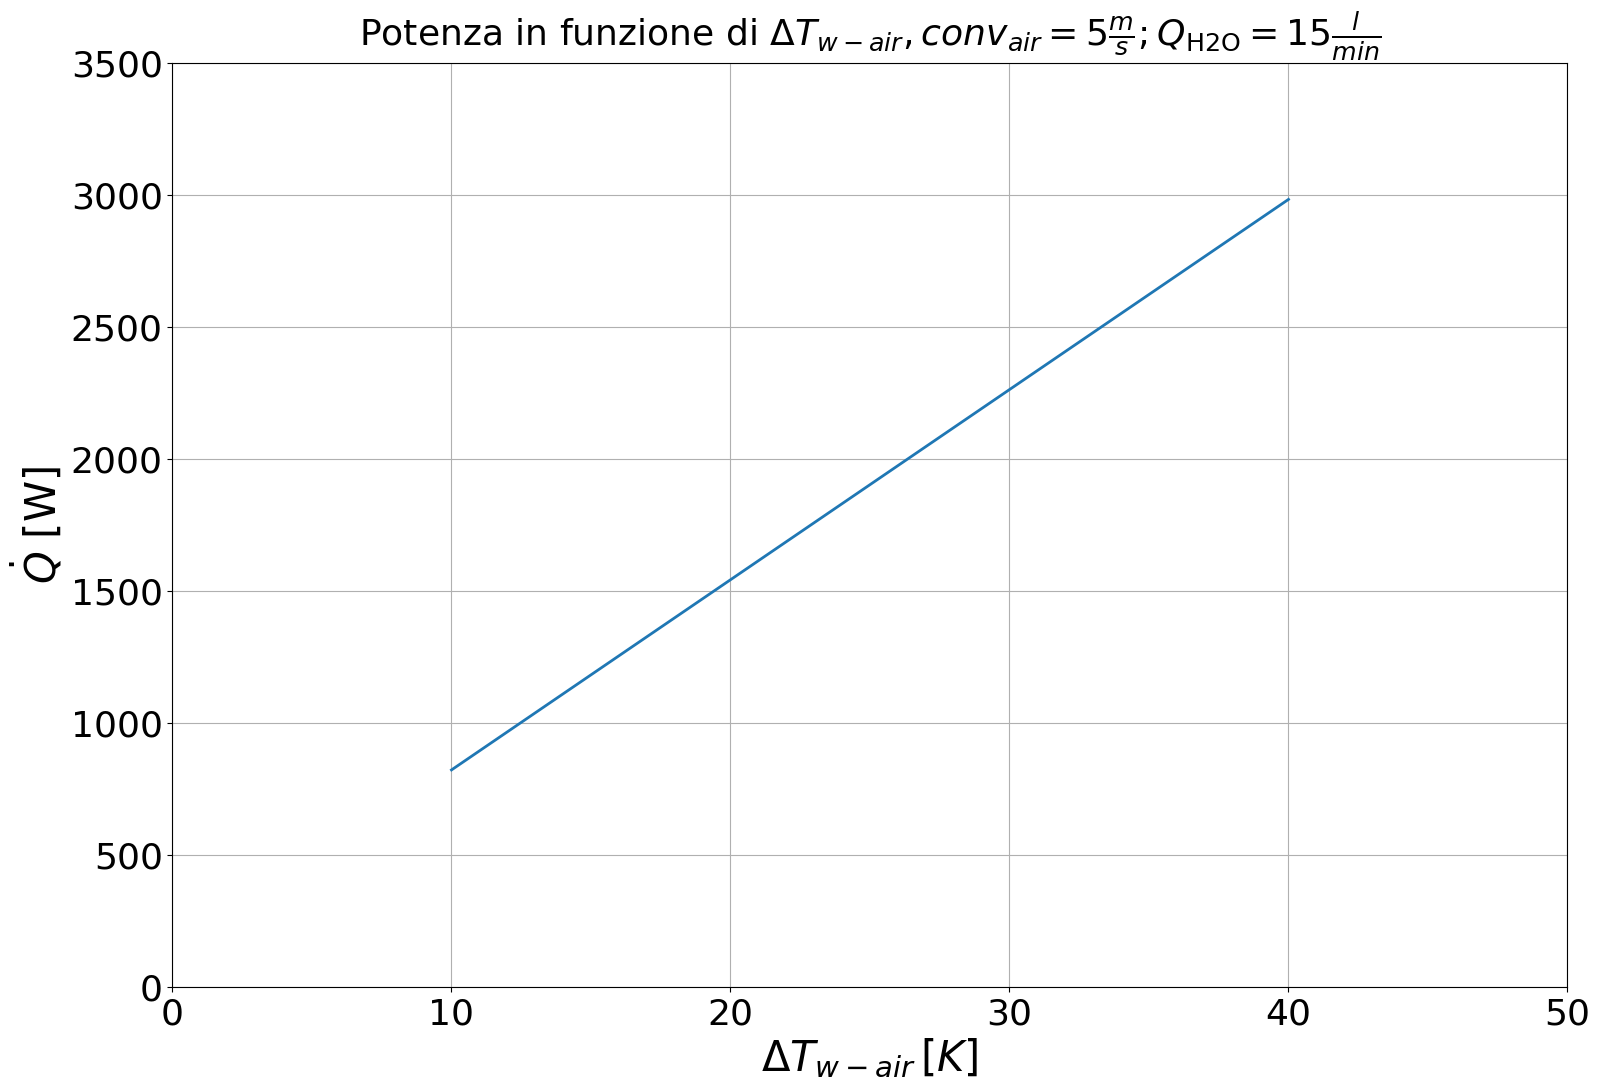

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crea il DataFrame con i tuoi dati
data = {
    'DT': [40, 30, 20, 10],
    'Q': [2970.3, 2277.7, 1541.4, 814.5]
}

df = pd.DataFrame(data)

# Colori distinti per il fitting lineare (usati codici esadecimali)
colors = ['#1f77b4']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=18 pollici, altezza=12 pollici)

# Estrai i valori da DataFrame
x = df['DT'].values  # Prendi i valori di DT
y = df['Q'].values   # Prendi i valori di potenza (Q)
fit_and_plot(x, y, r'$Q$ vs $ \Delta T$', colors[0])  # Aggiungi la retta di fitting

# Imposta le etichette e il titolo
plt.xlabel(r'$ \Delta T_{w-air} \, [K]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]', fontsize=30)
plt.title(r'Potenza in funzione di $\Delta T_{w-air}, con v_{air} = 5 \frac {m}{s}; Q_\text{H2O} = 15 \frac{l}{min} $', fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 50)  # Aggiungi un limite per l'asse x
plt.ylim(0, 3500)  # Aggiungi un limite per l'asse y

# Mostra il grafico
plt.show()






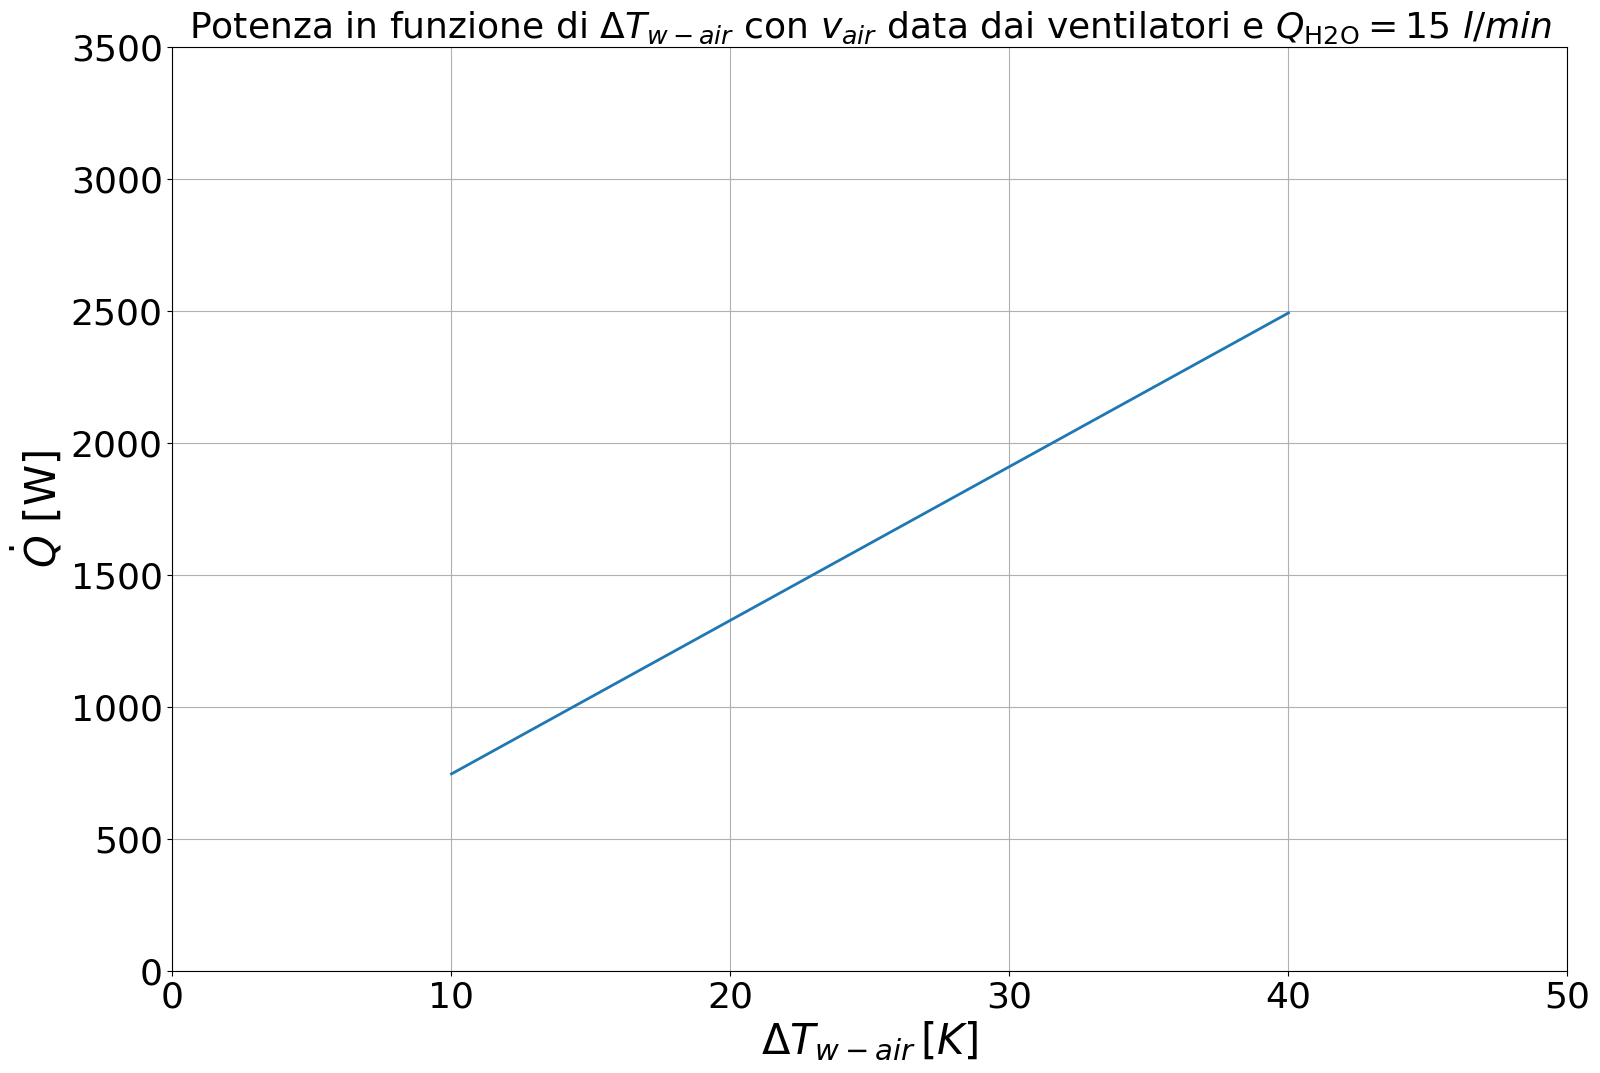

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crea il DataFrame con i tuoi dati
data = {
    'DT': [40, 30, 20, 10],
    'Q': [2490.408375, 1851.851517, 1442.408392, 686.7481833]
}

df = pd.DataFrame(data)

# Colori distinti per il fitting lineare (usati codici esadecimali)
colors = ['#1f77b4']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=18 pollici, altezza=12 pollici)

# Estrai i valori da DataFrame
x = df['DT'].values  # Prendi i valori di DT
y = df['Q'].values   # Prendi i valori di potenza (Q)
fit_and_plot(x, y, r'$Q$ vs $ \Delta T$', colors[0])  # Aggiungi la retta di fitting

# Imposta le etichette e il titolo
plt.xlabel(r'$ \Delta T_{w-air} \, [K]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]', fontsize=30)
plt.title(r'Potenza in funzione di $\Delta T_{w-air}$ con $v_{air}$ data dai ventilatori e $Q_\text{H2O}=15\ l/min$', fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 50)  # Aggiungi un limite per l'asse x
plt.ylim(0, 3500)  # Aggiungi un limite per l'asse y

# Mostra il grafico
plt.show()


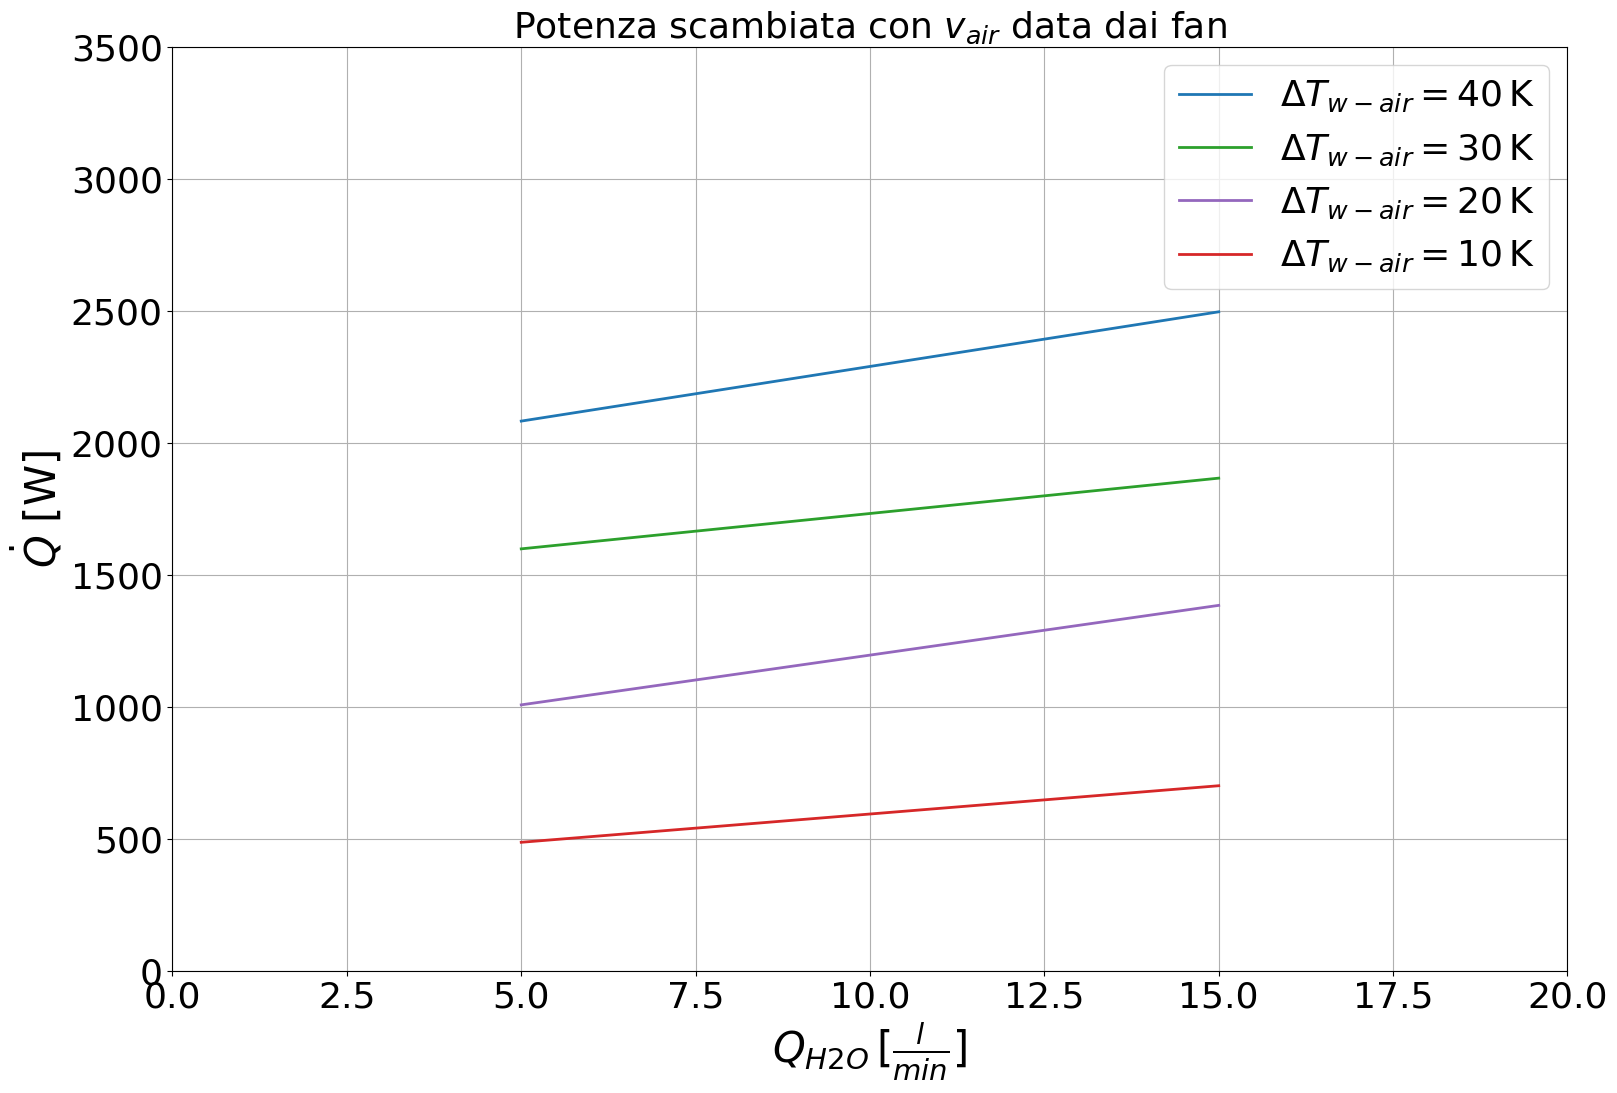

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definisci il percorso del file Excel
file_path = "C:/Users/MEDIA/Dropbox/Il mio PC (DESKTOP-5MOS4OL)/Desktop/TESI MAGISTRALE/Code_portate_5.xlsx"

# Carica il file Excel (header=0 indica che la prima riga contiene i nomi delle variabili)
df = pd.read_excel(file_path, header=0)

# Colori distinti per ogni fitting lineare (usati codici esadecimali)
colors = ['#1f77b4', '#2ca02c', '#d62728',  '#9467bd']

# Funzione per eseguire il fitting e la visualizzazione con colore specifico
def fit_and_plot(x, y, label, color):
    coefficients = np.polyfit(x, y, 1)  # Fitting lineare
    y_fit = np.polyval(coefficients, x)  # Valori del fitting
    plt.plot(x, y_fit, label=label, color=color, linewidth=2)  # Disegna la retta di fitting con colore

plt.figure(figsize=(18, 12))  # Imposta una figura più grande (larghezza=12 pollici, altezza=8 pollici)

# Prendi i primi 5 valori
x1 = df['Q_H2O [l/min]'].iloc[0:5].values
y1 = df['Power [W]'].iloc[0:5].values
fit_and_plot(x1, y1, r'$\Delta T_{w-air} = 40 \, \text{K}$', colors[0])

# Prendi i successivi 3 valori
x2 = df['Q_H2O [l/min]'].iloc[5:8].values
y2 = df['Power [W]'].iloc[5:8].values
fit_and_plot(x2, y2, r'$\Delta T_{w-air} = 30 \, \text{K}$', colors[1])

# Prendi i successivi 5 valori
x3 = df['Q_H2O [l/min]'].iloc[8:13].values
y3 = df['Power [W]'].iloc[8:13].values
fit_and_plot(x3, y3, r'$\Delta T_{w-air} = 20 \, \text{K}$', colors[3])

# Prendi gli ultimi 3 valori
x4 = df['Q_H2O [l/min]'].iloc[13:16].values
y4 = df['Power [W]'].iloc[13:16].values
fit_and_plot(x4, y4, r'$\Delta T_{w-air} = 10 \, \text{K}$', colors[2])

# Imposta le etichette e il titolo
plt.xlabel(r'$Q_{H2O} \, [\frac{l}{min}]$', fontsize=30)
plt.ylabel(r'$\dot{Q}$ [W]',fontsize=30)
plt.title(r'Potenza scambiata con $v_{air}$ data dai fan', fontsize=26)
plt.legend(fontsize=26)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=26)
plt.xlim(0, 20)
plt.ylim(0, 3500)

# Mostra il grafico
plt.show()

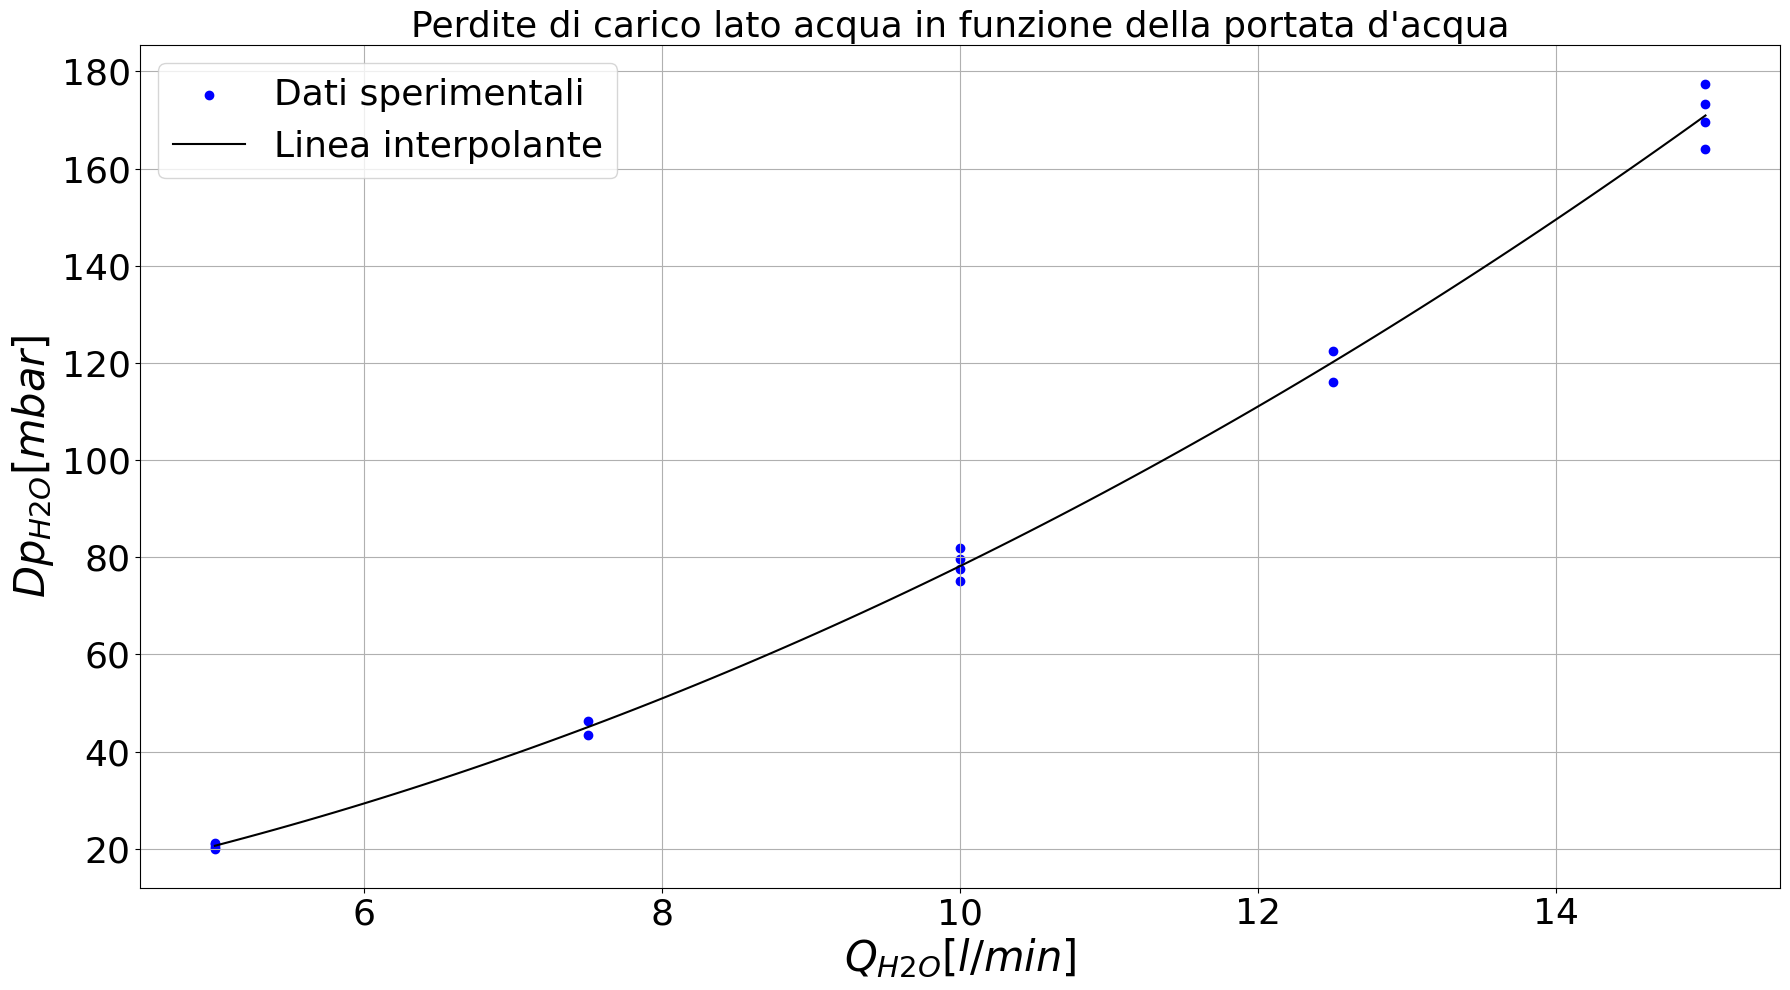

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Dati delle perdite di carico (Dp H2O in mbar)
dp_h2o = [164.0, 116.1, 75.2, 43.4, 19.9, 169.5, 77.6, 20.4, 173.4, 122.4, 79.7, 46.2, 20.9, 177.5, 82.0, 21.2]

# Dati della portata d'acqua (Q H2O in l/min)
q_h2o = [15.00, 12.50, 10.00, 7.50, 5.00, 15.00, 10.00, 5.00, 15.00, 12.50, 10.00, 7.50, 5.00, 15.00, 10.00, 5.00]

# Creazione del grafico scatter
plt.figure(figsize=(18, 10))
plt.scatter(q_h2o, dp_h2o, color='b', label='Dati sperimentali')

# Interpolazione polinomiale (grado 2 per un modello quadratico)
coeffs = np.polyfit(q_h2o, dp_h2o, 2)
polynomial = np.poly1d(coeffs)

# Generazione dei punti per la linea interpolante
q_h2o_fit = np.linspace(min(q_h2o), max(q_h2o), 100)
dp_h2o_fit = polynomial(q_h2o_fit)

# Plot della linea interpolante
plt.plot(q_h2o_fit, dp_h2o_fit, color='k', label='Linea interpolante')

# Etichette e titolo
plt.title('Perdite di carico lato acqua in funzione della portata d\'acqua', fontsize=26)
plt.xlabel(r'$Q_{H2O} [l/min]$', fontsize=30)
plt.ylabel(r'$ Dp_{H2O} [mbar] $', fontsize=30)

# Mostra la legenda e il grafico
plt.legend(fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.grid(True)
plt.tight_layout()
plt.show()
